複習筆記: 2021.10.31

## 建構 Optimal Risky Portfolios (N Assets)

### 創建虛擬標的

In [1]:
import numpy as np
import pandas as pd

# 創建 100 筆股票 A、B、C 的歷史平均數與標準差 (假設股票報酬為常態分佈)
mu_A = 0.05
sig_A = 0.15
mu_B = 0.08
sig_B = 0.20
mu_C = 0.12
sig_C = 0.225

A = pd.DataFrame(np.random.normal(mu_A, sig_A, size=(100, 1)), columns=list('A'))
B = pd.DataFrame(np.random.normal(mu_B, sig_B, size=(100, 1)), columns=list('B'))
C = pd.DataFrame(np.random.normal(mu_C, sig_C, size=(100, 1)), columns=list('C'))

df = pd.concat([A, B, C], axis=1)
df.head()


,A,B,C
0,-0.049967,-0.017656,0.132227
1,-0.095784,-0.071821,0.373808
2,0.026249,0.324763,-0.018976
3,-0.292444,0.164978,0.244533
4,0.026992,0.166835,0.218756


### 計算虛擬標的的 sample mean 與 variance-covariance matrix

In [4]:
R = df.mean()
COV = df.cov()

print('Sample mean:')
print(R)
print('Sample variance-covariance matrix:')
print(COV)

Sample mean:
A    0.044884
B    0.050464
C    0.102852
dtype: float64
Sample variance-covariance matrix:
          A         B         C
A  0.025361 -0.000349 -0.007047
B -0.000349  0.046090  0.000957
C -0.007047  0.000957  0.049778


### 計算 minimun variance portfolio (MVP)

目標是最小化投組變異數 ($\sigma_{p}^{2}$)，作法是找出權重矩陣 (w) 【也就是決定 A, B, C 個要投資多少比例】  
這裡會用到:  
- 矩陣微分
- Lagrangian method

$$W_{GMVP} = \frac{\sum^{-1}1}{1^{T}\sum^{-1}1}$$

In [12]:
from numpy.linalg import inv # inv = inverse
import math

ONE = np.ones(3) # 3*3 單位矩陣
InvCOV = inv(COV) 
W_GMVP = (InvCOV @ ONE) / (ONE.T @ InvCOV @ ONE)
print('W_GMVP')
print(W_GMVP)
print(np.sum(W_GMVP)) # 投組比例總和必須是 1

ret_GMVP = W_GMVP @ R # 報酬率就是算出來的投組矩陣乘上個標的的期望報酬
print('ret_GMVP')
print(ret_GMVP)

sig_GMVP = math.sqrt(W_GMVP.T @ COV @ W_GMVP) 
# 根據 Lecture 6 筆記第 6 頁，N 個 assets 的投組變異數為 W.T (var-cov matrix) W
print('sig_GMVP:')
print(sig_GMVP)

W_GMVP
[0.49579387 0.22665756 0.27754857]
1.0
ret_GMVP
0.06223753279752023
sig_GMVP:
0.10266047776794197


### 計算 maximum Sharpe ratio portfolio (MSRP)

MSRP 的特色:  
- 投組內全部都是 risky assets
- 是由效用函數對權重矩陣 (w) 的微分得出的   
$$W_{MSRP} = \frac{\sum^{-1}[E[R]-r_{f}1]}{1^{T}\sum^{-1}[E[R]-r_{f}1]}$$

In [15]:
r_f = 0.01 # 假設 risk-free asset 的報酬率為 1%

ONE = np.ones(3)
ER = R - r_f # 矩陣減去常數，代表超額報酬
InvCOV = inv(COV)

W_MSRP = (InvCOV @ ER) / (ONE @ InvCOV @ ER)
ret_MSRP = W_MSRP @ R
sig_MSRP = math.sqrt(W_GMVP.T @ COV @ W_GMVP) 

SR_MSRP = (ret_MSRP - r_f)/sig_MSRP # 得到再 MSRP 那點上的斜率

print('MSRP:')
print(W_MSRP)
print('ret_MSRP:')
print(ret_MSRP)
print('sig_MSRP:')
print(sig_MSRP)

MSRP:
[0.39921397 0.17123159 0.42955444]
ret_MSRP:
0.07073973422553895
sig_MSRP:
0.10266047776794197


### 追蹤整個 minimum variance frontier 

藉由更改 u，可以變動投組中 GMVP 與 MSRP 的比例，

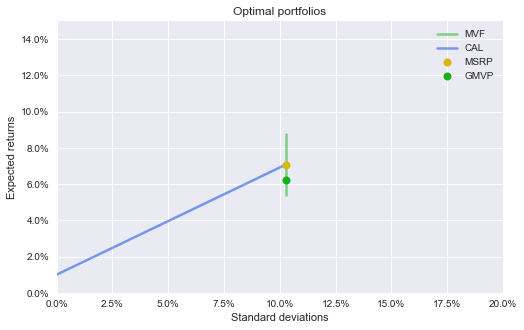

In [20]:
W = np.linspa   ce(-2, 2, 100, endpoint=True) # 隨機取出兩不同投組的權重
# 意思是最多可以放空 200% 的純 GMVP 組合，並作多 200% 的純 MSRP 組合
ret_MVF = [] # MVF = minimum variance frontier，放 return 的資料 (等一下畫圖的 y 軸)
sig_MVF = [] # 等一下畫圖的 x 軸

for u in W:
    ret_MVF.append(u*ret_GMVP + (1-u)*ret_MSRP)
    sig_MVF.append(
        math.sqrt(u**2 * sig_GMVP**2 + (1-u)**2 * sig_MSRP**2 + 
        2*u*(1-u)*np.cov()
    )

CAL_x = np.linspace(0, np.max(sig_MVF), 50, endpoint=50)
CAL_y = r_f + SR_MSRP*CAL_x
# 畫出在極大化 sharpe ratio 下的資本配置線

# 將 MVF (由 linspace 隨機生成)、CAL (極大化 Sharpe ratio 的那條)、MSRP (CAL 與 MVF 相切點)、
# GMVP (N 個 assets 的投資組合中，變異數最小的那一點)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)

plt.plot(sig_MVF, ret_MVF, color='xkcd:green', linewidth=2.5, alpha=0.5)
plt.plot(CAL_x, CAL_y, color='xkcd:blue', linewidth=2.5, alpha=0.5)
plt.plot(sig_MSRP, ret_MSRP, 'o', color='xkcd:gold', markersize=8)
plt.plot(sig_GMVP, ret_GMVP, 'o', color='xkcd:green', markersize=8)

plt.ylabel('Expected returns')
plt.xlabel('Standard deviations')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.legend(['MVF', 'CAL', 'MSRP', 'GMVP'], loc='best')
plt.title('Optimal portfolios')
plt.xlim([0, 0.2])
plt.ylim([0, 0.15])
plt.show()


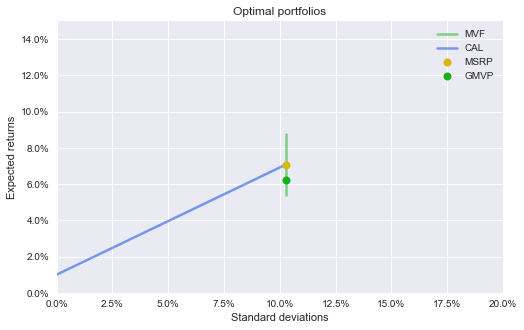

In [23]:
W = np.linspace(-2, 2, 100, endpoint=True)
ret_MVF = []
sig_MVF = []
for u in W:
    ret_MVF.append(u*ret_GMVP + (1-u)*ret_MSRP)
    sig_MVF.append(math.sqrt(u**2 * sig_GMVP**2 + (1-u)**2 * sig_MSRP**2 +
    2*u*(1-u)*np.dot(W_GMVP, np.dot(COV, W_MSRP))))
    CAL_x = np.linspace(0, np.max(sig_MVF), 50, endpoint=True)
CAL_y = r_f + SR_MSRP*CAL_x
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
plt.plot(sig_MVF, ret_MVF, color='xkcd:green', linewidth=2.5, alpha=0.5)
plt.plot(CAL_x, CAL_y, color='xkcd:blue', linewidth=2.5, alpha=0.5)
plt.plot(sig_MSRP, ret_MSRP, 'o', color='xkcd:gold', markersize=8)
plt.plot(sig_GMVP, ret_GMVP, 'o', color='xkcd:green', markersize=8)
plt.ylabel('Expected returns')
plt.xlabel('Standard deviations')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(['MVF', 'CAL', 'MSRP', 'GMVP'], loc='best')
plt.title('Optimal portfolios')
plt.xlim([0, 0.2])
plt.ylim([0, 0.15])
plt.show()